This notebook aims to give an informal solution for the exercises 1.22 and 1.23 from the BRML book of David Barber (http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/200620.pdf)

Step 1 : Load libraries

In [14]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt
from tqdm import tqdm

Step 2 : import the data

In [4]:
df1 = pd.read_csv("/Users/ilanasebag/Desktop/CSML_UCL/COMP0080 - GRAPHICAL MODELS/CW1/vi_values.csv", header = None)
df2 = pd.read_csv("/Users/ilanasebag/Desktop/CSML_UCL/COMP0080 - GRAPHICAL MODELS/CW1/mean_values.csv", header = None)
v_data = df1.to_numpy()[:, 0]
v_data_mean = df2.to_numpy()[:, 0]

Step 3 : Define the parameters

In [5]:
S = 2000 # number of points on the spiral
sd = 0.2 # standard deviation of the Gaussian noise
N = 30 # number of stations
rate = 25
using_mean_sensor = True #choose which section you want to get the plots and return outputs for; section 1 = False, section 2 = True  

Step 4 : Define all the functions 

In [ ]:
#1st type of sensor

def value(x1_true, y1_true, x2_true, y2_true, x_sensor, y_sensor): 
    return 1/(0.1+ (x1_true-x_sensor)**2 + (y1_true-y_sensor)**2) + 1/(0.1+ (x2_true-x_sensor)**2 + (y2_true-y_sensor)**2)

In [ ]:
#2nd type of sensor - using mean data

def value_mean(x1_true, y1_true, x2_true, y2_true, x_sensor, y_sensor): 
    return 0.5/(0.1+ (x1_true-x_sensor)**2 + (y1_true-y_sensor)**2) + 0.5/(0.1+ (x2_true-x_sensor)**2 + (y2_true-y_sensor)**2)


In [7]:
def earthquake(S, sd, N, rate, v_data):

#Creating spiral polar coordinates
    rs=np.zeros(S)
    thetas = np.zeros(S)
    x = np.zeros(S)
    y = np.zeros(S)
    for s in range(S):
        theta = rate*2*np.pi*s/S
        r = s/S
        x[s] = r*np.cos(theta)
        y[s] = r*np.sin(theta)
        thetas[s] = theta
        rs[s] = r

    # def the locations of the detection stations on the surface
    # def what value on each sensor would be generated by an explostion at internal location S1 and S2
    posterior = np.zeros(S)
    likelihood = np.zeros([S, S])
    x_sensor = np.zeros(N)
    y_sensor = np.zeros(N)
    v = np.zeros((S, S, N))

    for s2 in tqdm(range(S)):
        for s1 in range(S):
            for sensor in range(N):
                theta_sensor = 2*math.pi*sensor/N
                x_sensor[sensor] = math.cos(theta_sensor)
                y_sensor[sensor] = math.sin(theta_sensor)
                if using_mean_sensor == False:
                    v[s2,  s1, sensor] = value(x[s1], y[s1], x[s2], y[s2], x_sensor[sensor], y_sensor[sensor]) # normal explosion value
                else:
                    v[s2,  s1, sensor] = value_mean(x[s1], y[s1], x[s2], y[s2], x_sensor[sensor], y_sensor[sensor]) # Mean explosion value

            diff = v_data - v[s2][s1]
            likelihood[s2][s1] = np.product(1 / (sd*(2*np.pi)**(1/2)) * np.exp((-1/2)*((diff)/sd)**2))
    
    # marginalize over s2
    likelihood = np.sum(likelihood, axis=0)

    #calculation of posterior, max posterior and location of max posterior
    posterior = likelihood / np.sum(likelihood)
    maxposterior = max(posterior)
    max_ind = np.argmax(posterior)
    s1_x = x[max_ind]
    s1_y = y[max_ind]
      
    #Q2 return: p(v|H2) by summing over all S1s and S2s
    p_v_H2 = np.sum(likelihood)/2000**2
    
    return posterior, max(posterior), x, y, rs, thetas, s1_x, s1_y, p_v_H2

In [8]:
# 1 explosion model to calculate p(v|H1), same as before just change of value function and loops only through one S

def value_1(x, y, x_sensor, y_sensor): 
    return 1/(0.1+ (x - x_sensor)**2 + (y - y_sensor)**2)

In [9]:
def eq_1(v_data):

    rs=np.zeros(S)
    thetas = np.zeros(S)
    x = np.zeros(S)
    y = np.zeros(S)
    for s in range(S):
        theta = rate*2*np.pi*s/S
        r = s/S
        x[s] = r*np.cos(theta)
        y[s] = r*np.sin(theta)
        thetas[s] = theta
        rs[s] = r

    # def the locations of the detection stations on the surface
    # def what value on each sensor would be generated by an explostion at internal location s

    posterior = np.zeros(S)
    likelihood = np.zeros(S)
    x_sensor = np.zeros(N)
    y_sensor = np.zeros(N)
    v = np.zeros((S, N))

    for s in tqdm(range(S)):
        for sensor in range(N):
            theta_sensor = 2*math.pi*sensor/N
            x_sensor[sensor] = math.cos(theta_sensor)
            y_sensor[sensor] = math.sin(theta_sensor)
            v[s, sensor] = value_1(x[s], y[s], x_sensor[sensor], y_sensor[sensor]) # explosion value

        diff = v_data - v[s]
        likelihood[s] = np.product(1 / (sd*(2*np.pi)**(1/2)) * np.exp((-1/2)*((diff)/sd)**2))
    

    p_v_H1 = np.sum(likelihood)/2000

    return p_v_H1

In [10]:
#Outputs for question 1 which are conserved as variable to use them for question 2 and plots found below:

# for 1st section using normal sensor data:
if using_mean_sensor == False:   
    posterior, maxpos, x, y, rs, thetas, s1_x, s1_y, p_v_H2 = earthquake(S, sd, N, rate, v_data)
    p_v_H1 = eq_1(v_data)
else:
#for 2nd section using mean sensor data
    posterior, maxpos, x, y, rs, thetas, s1_x, s1_y, p_v_H2 = earthquake(S, sd, N, rate, v_data_mean)
    p_v_H1 = eq_1(v_data_mean)

#print statement for question 2
print(np.log(p_v_H2) - np.log(p_v_H1))


100%|██████████| 2000/2000 [00:00<00:00, 11872.31it/s]

15.965927727784468


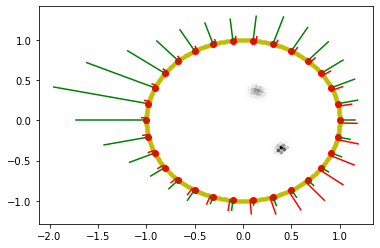

In [13]:
#Data Visualisation section: Earth plot + Posterior intensity plots + measured 
# and theoretical values magnitude lines (green and red) for each sensors

sensor = np.arange(N)

theta_sensor = 2*math.pi*sensor/N
x_sensor = np.cos(theta_sensor)
y_sensor = np.sin(theta_sensor)

red1 = 1 / (0.1 + (s1_x - x_sensor)**2 + (s1_y - y_sensor)**2)
red1 = red1 / np.max(v_data)
v_data1 = v_data/np.max(v_data)
rs_p = 1 + v_data1
rs_r1 = 1 + red1
theta_red = theta_sensor - np.pi/100
theta_pur = theta_sensor 
x_p1 = x_sensor
y_p1 = y_sensor
# x0y coordinates
x_p2 = rs_p*np.cos(theta_pur)
y_p2= rs_p*np.sin(theta_pur)

x_r1= np.cos(theta_red)
y_r1= np.sin(theta_red) 

x_r2 = rs_r1*np.cos(theta_red)
y_r2 = rs_r1*np.sin(theta_red)  

plt.figure()

for s in range(S):
    plt.plot(x[s],y[s],".", color=(1-(posterior[s]/maxpos))*np.array([1,1,1]))
for theta in np.arange(0,2*np.pi,0.01):
    plt.plot(np.cos(theta),np.sin(theta),"y.")

for theta in theta_sensor:
    plt.plot(np.cos(theta),np.sin(theta),"ro")

for s in range(N):
    plt.plot([x_p1[s],x_p2[s]],[y_p1[s],y_p2[s]],'g')
    plt.plot([x_r1[s],x_r2[s]],[y_r1[s],y_r2[s]],'r')    
    
plt.show()